In [15]:
from data import saveResult_seg, predictGenerator_seg, postprocess
from model import unet_seg
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from PIL import Image
from numpy import asarray
import os
import tensorflow as tf
import tifffile
from skimage.exposure import rescale_intensity
import skimage
from skimage.morphology import opening
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
# Files:
DeLTA_data = '/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/preprocessed/'
training_set = DeLTA_data
model_file = DeLTA_data + 'saved-model-nosmall-72.hdf5'
#inputs_folder = DeLTA_data + 'mother_machine/evaluation/preprocessed/img/'
#outputs_folder = DeLTA_data + 'mother_machine/evaluation/seg_output/'
model_file

'/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/preprocessed/saved-model-nosmall-72.hdf5'

In [16]:
image_dirs = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches/trench_04/"

stack = np.zeros((25,640,64))
for x in range(25):
    test = tifffile.imread(image_dirs+"T_0{}.tif".format(str(x).zfill(2)))
    image = rescale_intensity(test)
    image = skimage.img_as_ubyte(image)
    LEFT_CROP = 3
    RIGHT_CROP = LEFT_CROP + 35
    image = image[15:-15,LEFT_CROP:RIGHT_CROP]
    image = Image.fromarray(image).rotate(0)
    image = image.resize((64,640))
    image = np.array(image).astype(np.float64)
    stack[x,:,:] = image
#stack = tifffile.imread("/home/georgeos/Documents/GitHub/SYMPTOMM2/prototyping/real_image_for_hist_match_stack.tif")
_ = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/preprocessed/CROPPED_FILTERED/synth_801.tif")


In [17]:
stack1 = stack[5:,:,:]

In [18]:
target_size = (640, 64)
input_size = target_size + (1,)
process_size = 4096
# Load up model:
model = unet_seg(input_size = input_size)
model.load_weights(model_file)
prediction = model.predict(stack1.reshape(25-5,640,64,1))



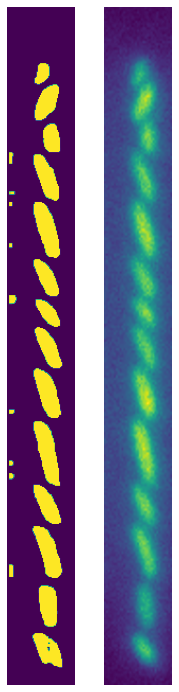

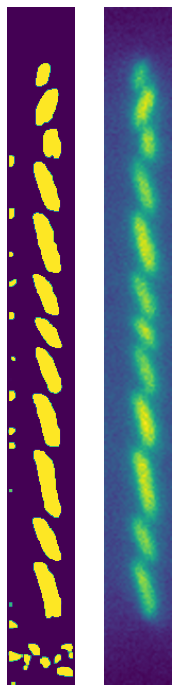

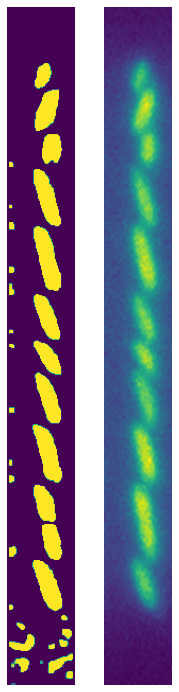

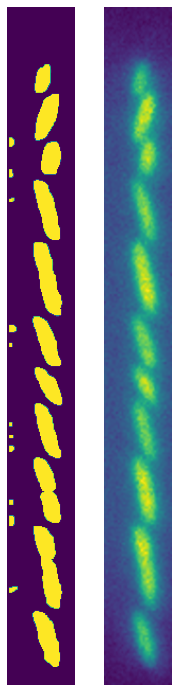

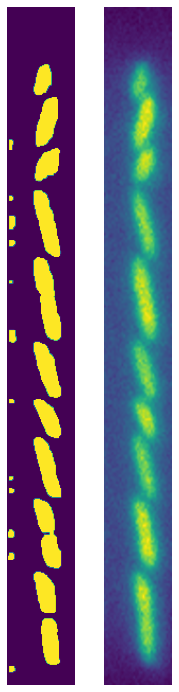

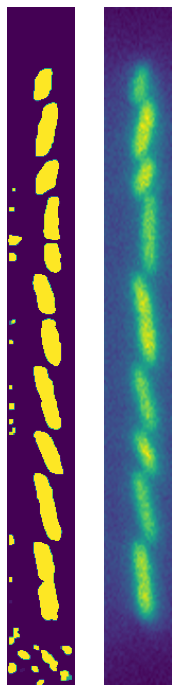

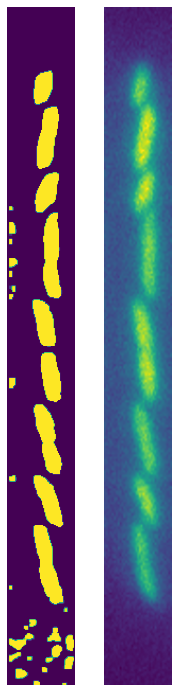

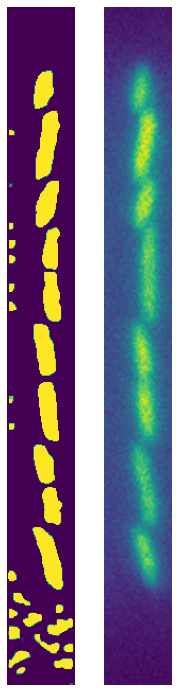

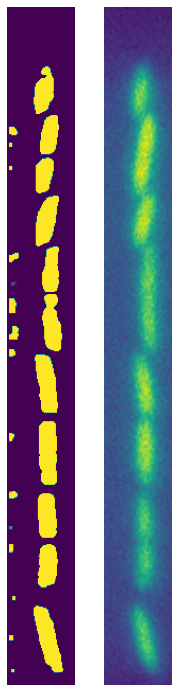

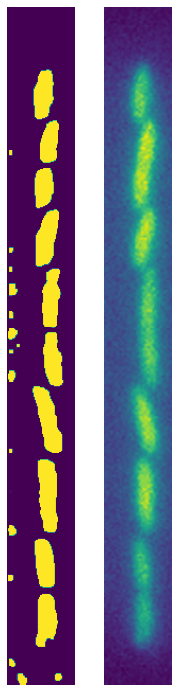

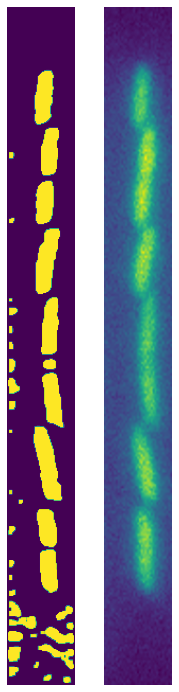

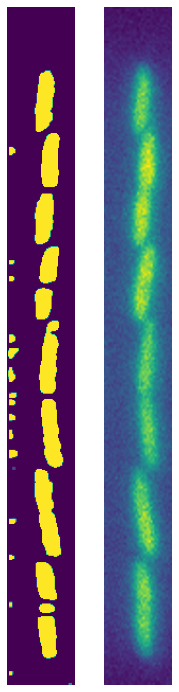

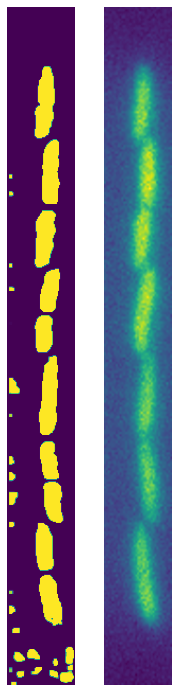

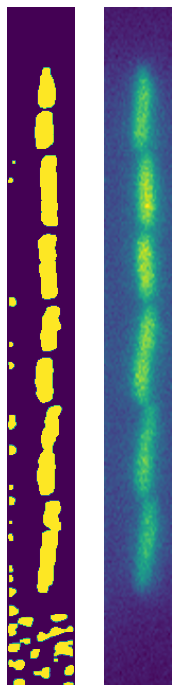

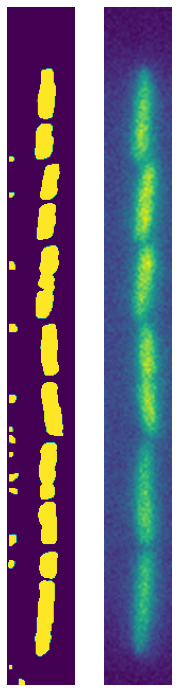

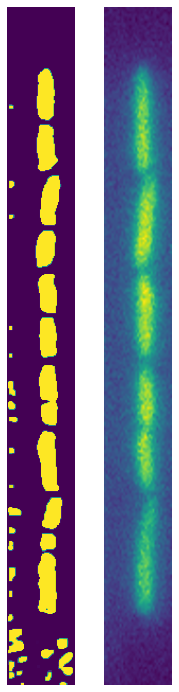

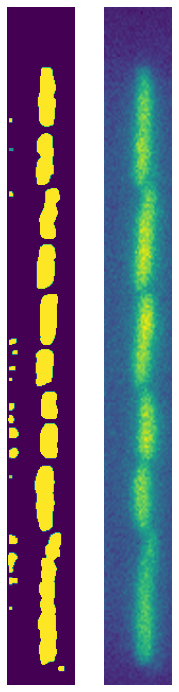

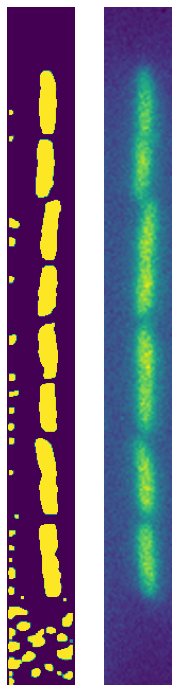

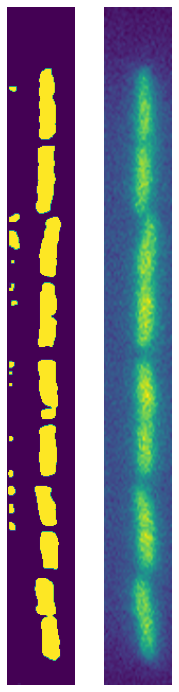

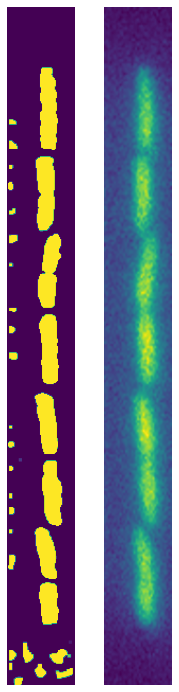

In [19]:
for x in range(25-5):
    fig, axs = plt.subplots(1,2,figsize=(3,10))
    axs[0].imshow(opening(prediction[x].reshape(640,64), np.ones((3,3)))), axs[1].imshow(stack1[x].reshape((640,64)))
    plt.tight_layout()
    for ax in axs:
      ax.axis("off")
    #plt.savefig("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/figure/{}.png".format(str(x)))

In [3]:
cropped_ims = []
for x in range(stack.shape[0]):
    image = stack[x,:,:]
    image = np.array(image)
    image = rescale_intensity(image)
    image = skimage.img_as_ubyte(image)
    LEFT_CROP = 3
    RIGHT_CROP = LEFT_CROP + 16
    image = image[:,LEFT_CROP:RIGHT_CROP]
    HEIGHT = image.shape[0]
    WIDTH = image.shape[1]
    NEW_HEIGHT = int(np.ceil(HEIGHT*2/64) * 64)
    NEW_WIDTH = int(2 ** np.ceil(np.log2(WIDTH*2)))
    image = Image.fromarray(image).rotate(0)
    image = image.resize((NEW_WIDTH,NEW_HEIGHT))
    image = np.array(image).astype(np.float64)
    cropped_ims.append(image)

NameError: name 'stack' is not defined

In [ ]:
cropped_ims[0].shape
stack_cropped = np.zeros((stack.shape[0],NEW_HEIGHT,NEW_WIDTH,1))
for x in range(len(cropped_ims)):
    stack_cropped[x,:,:,0] = cropped_ims[x]

In [ ]:

#image = np.random.rand(NEW_HEIGHT,NEW_WIDTH)*255
#plt.imshow(image)
#plt.show()
# Parameters:
target_size = (640, 64)
input_size = target_size + (1,)
process_size = 4096
# Load up model:
model = unet_seg(input_size = input_size)
model.load_weights(model_file)
prediction = model.predict(stack_cropped.reshape(len(cropped_ims),NEW_HEIGHT,NEW_WIDTH,1))
prediction = prediction.reshape(len(cropped_ims),NEW_HEIGHT,NEW_WIDTH)

In [ ]:
target_size

In [ ]:
for x in range(len(cropped_ims)):
    fig, axs = plt.subplots(1,2,figsize=(2,4))
    axs[0].imshow(prediction[x]), axs[1].imshow(cropped_ims[x])
    plt.tight_layout()
    for ax in axs:
      ax.axis("off")
    plt.savefig("/home/georgeos/Documents/GitHub/SYMPTOMM2/training_data/output_segmentations/output_{}.png".format(str(x).zfill(3)))

In [ ]:
model.summary()

In [ ]:
image = Image.open("/home/georgeos/Documents/MMSynth_data/FalsePosNeg_HADA/raw_data/ID_postGrowth_A01_BF.tif")
LEFT = 905
image = asarray(image)[395:395+192,LEFT:LEFT+32]
HEIGHT = image.shape[0]
WIDTH = image.shape[1]
NEW_HEIGHT = int(np.ceil(HEIGHT/64) * 64)
NEW_WIDTH = int(2 ** np.ceil(np.log2(WIDTH)))
image = Image.fromarray(image).rotate(180)
image = image.resize((NEW_WIDTH,NEW_HEIGHT))
image = np.array(image)
plt.imshow(image)
plt.show()
# Parameters:
target_size = (NEW_HEIGHT,NEW_WIDTH)
input_size = target_size + (1,)
process_size = 4096

# Load up model:
model = unet_seg(input_size = input_size)
model.load_weights(model_file)
prediction = model.predict(image.reshape(1,NEW_HEIGHT,NEW_WIDTH,1))
plt.imshow(prediction.reshape(192,32))
plt.show()

In [ ]:
plt.imshow(postprocess(prediction[:,:,:,0]))